# Setup

In [10]:
import warnings

import numpy as np
from matplotlib import pyplot as plt

from compare_variance_residual.simulated.plotting import plot_experiment
from compare_variance_residual.simulated.simulation import run_experiment, generate_dataset

warnings.simplefilter(action='ignore')
plt.style.use('ggplot')

In [11]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

# Set default values to be used in the tests

In [12]:
n_observations = 3

variables = dict(
    # dataset
    n_runs=10,
    d_shared=50,
    d_unique_list=[50, 50],
    n_targets=100,
    n_samples_train=100,
    n_samples_test=50,
    noise_level=0.1,
    random_distribution="normal",

    # ridge regression
    alphas=np.logspace(-4, 4, 9),
    cv=10,

    # method parameters
    direct_variance_partitioning=False,
    ignore_negative_r2=False,
    use_ols=False,
)

# Varying distributions

In [13]:
variable_name = "sampling distribution"
random_distributions = [
    "normal",
    "uniform",
    "exponential",
    "gamma",
    "beta",
    "lognormal",
    "pareto"
]

In [14]:
predicted_variance, predicted_residual = run_experiment(random_distributions, variable_name, **variables)

[.................                       ] 43% | 19.72 sec | Varying sampling distribution | 

KeyboardInterrupt: 

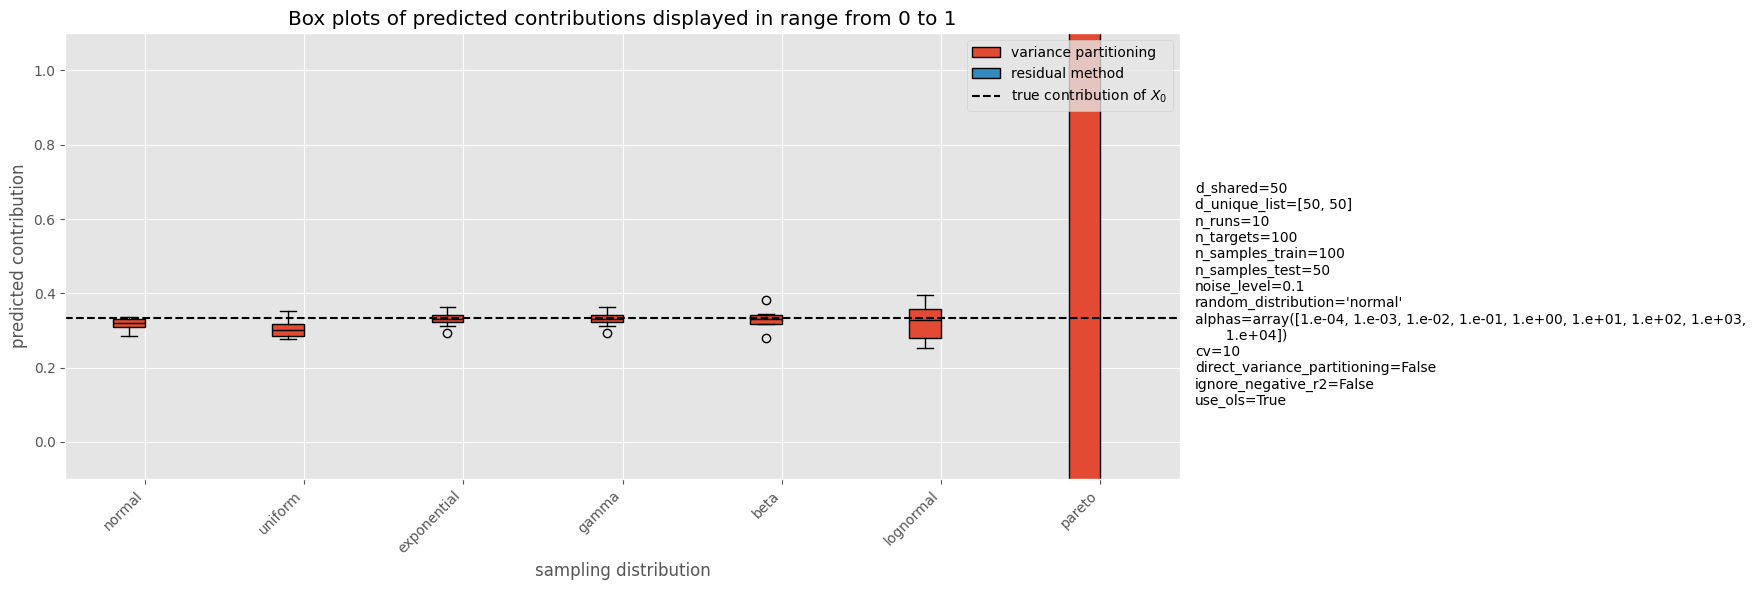

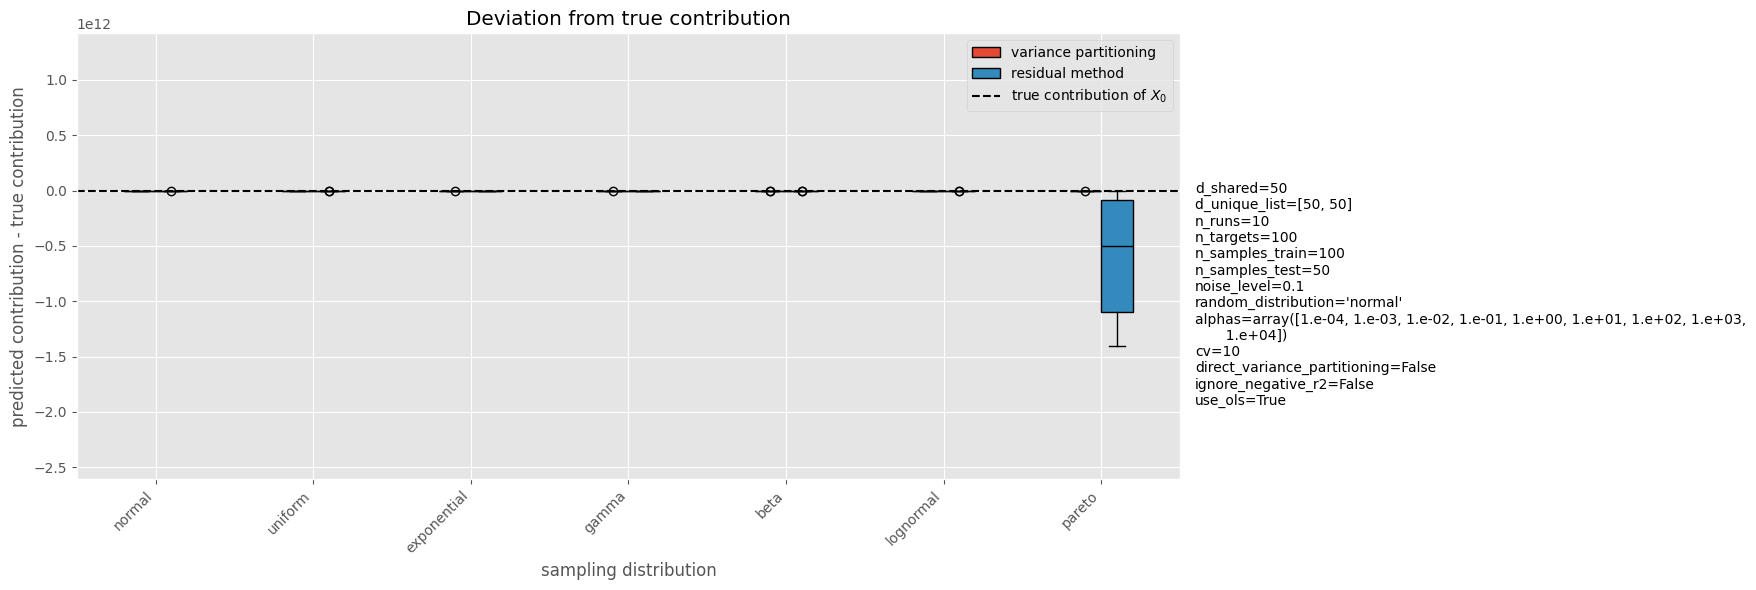

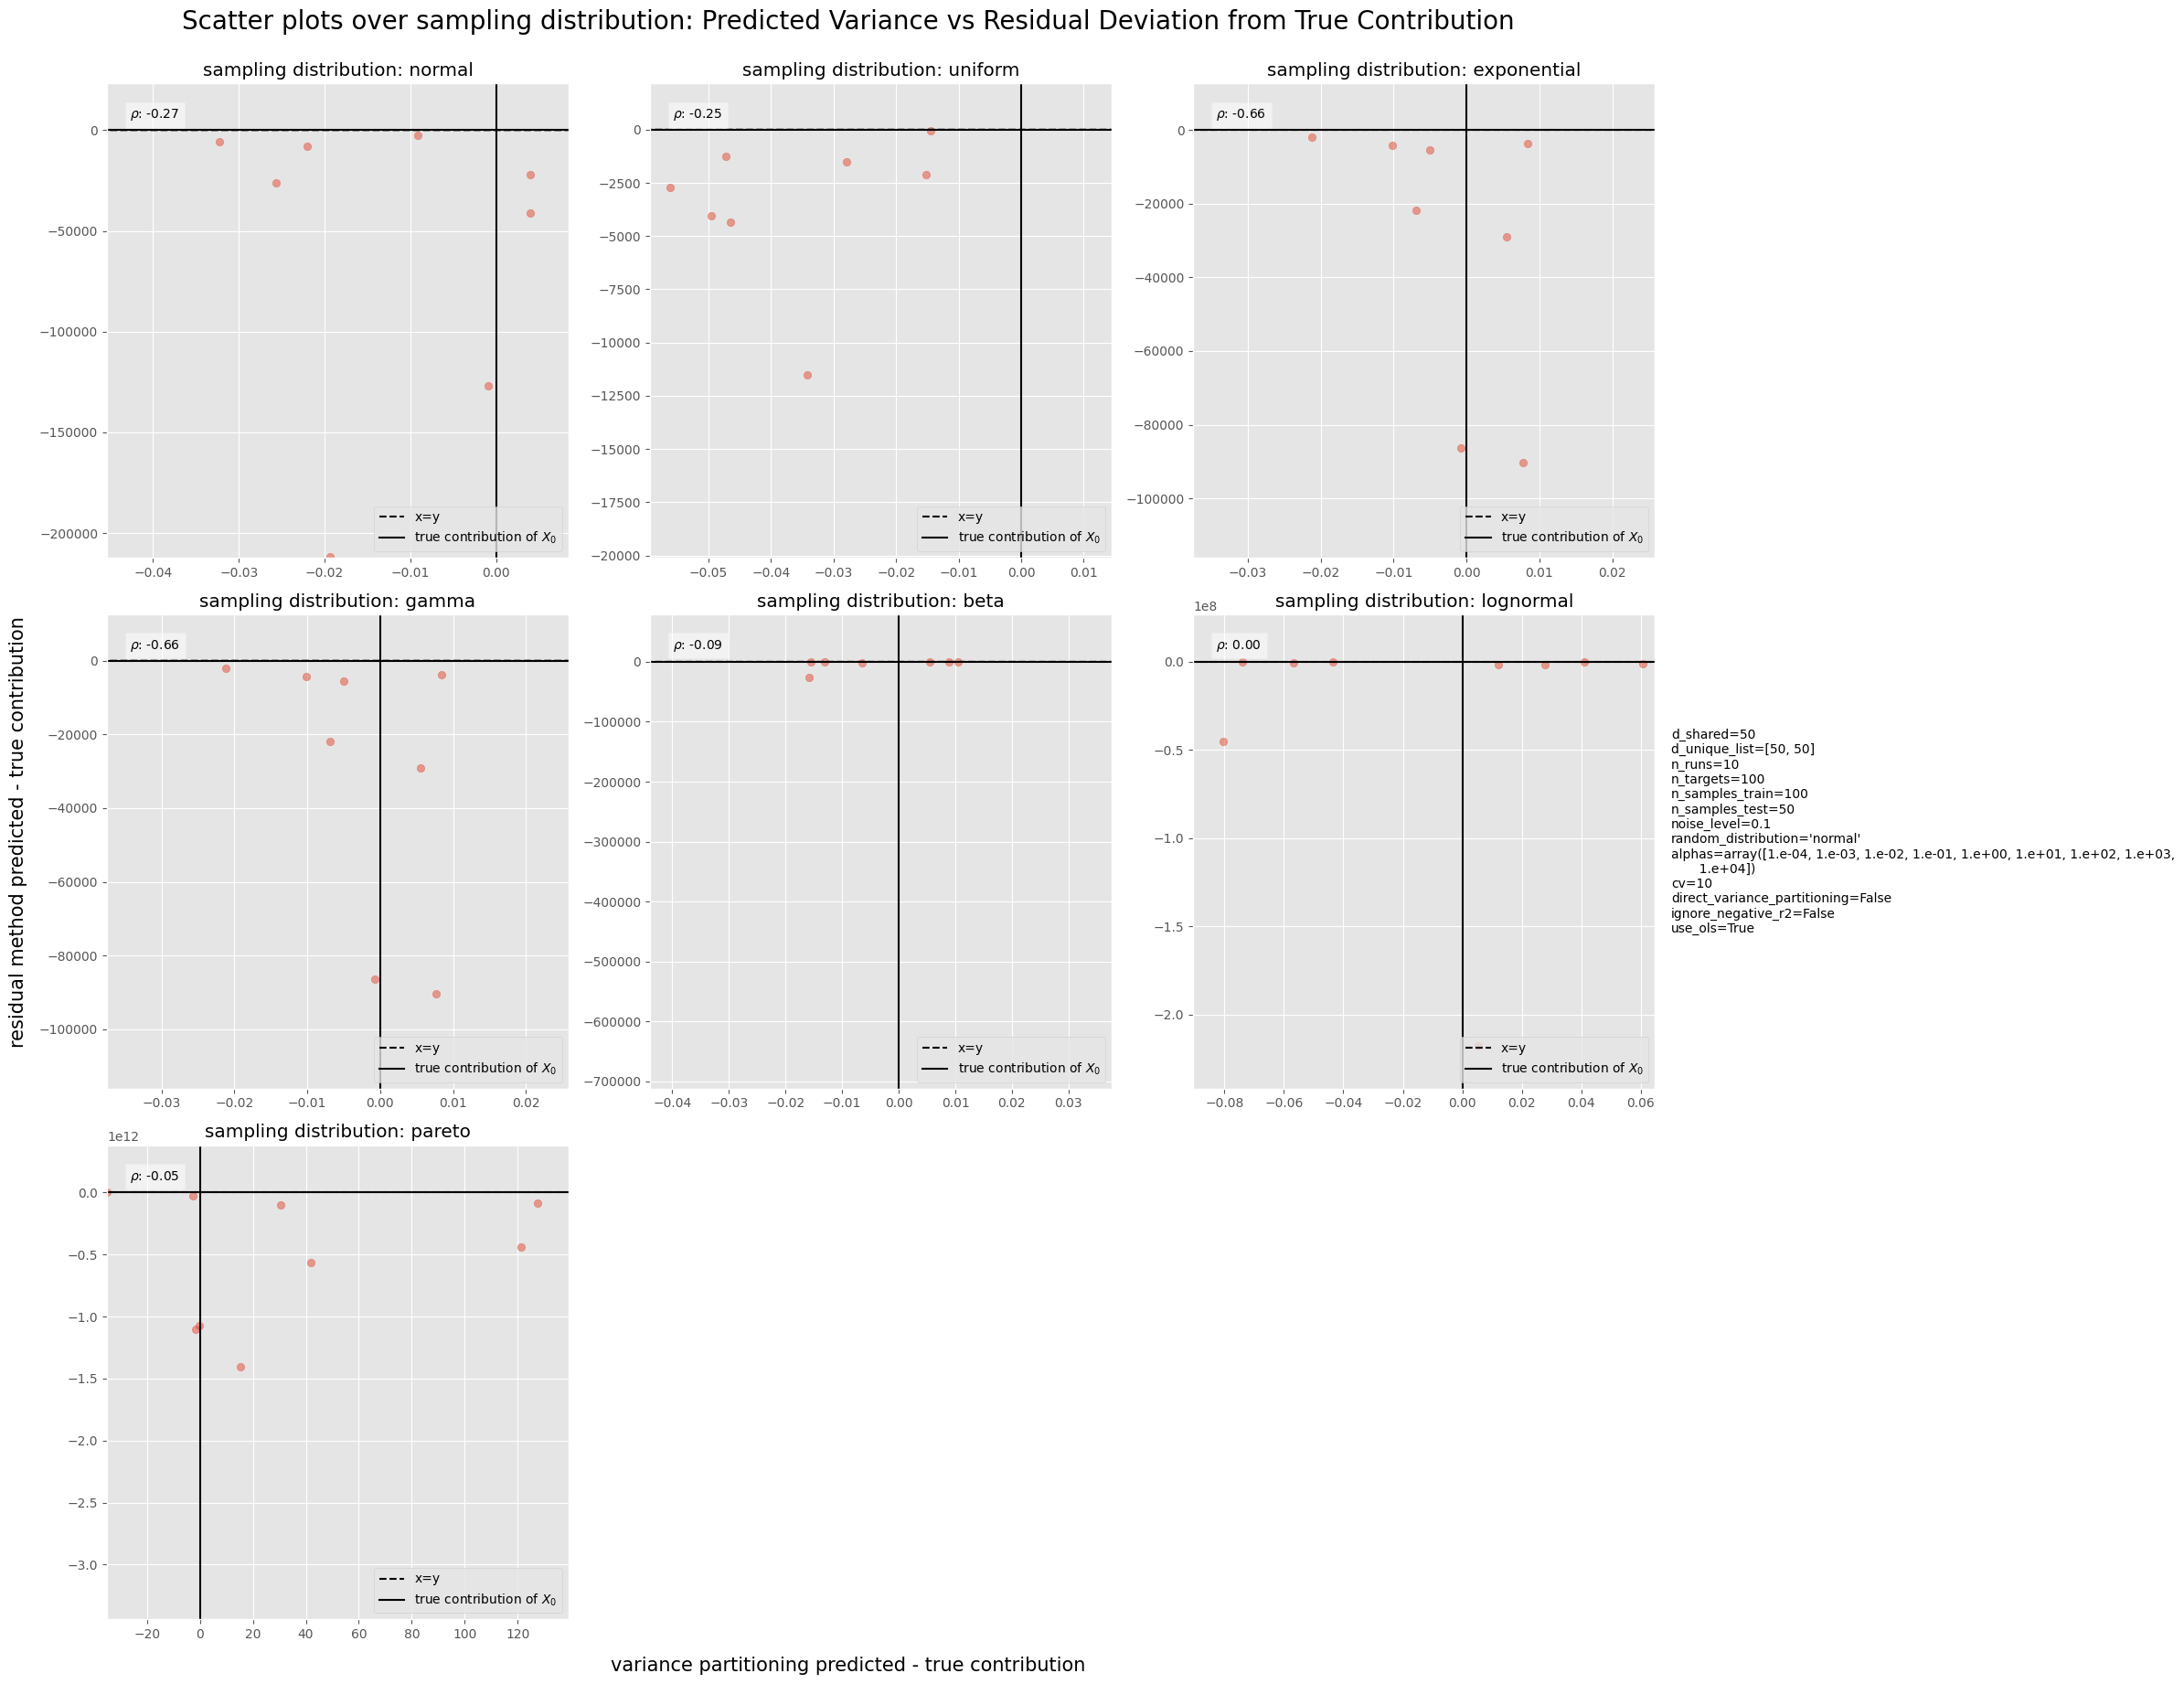

In [6]:
plot_experiment(random_distributions, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying sample sizes

In [7]:
sample_sizes = np.logspace(1, 3, n_observations)

## varying train sample sizes

In [8]:
variable_name = "sample size training"

In [9]:
predicted_variance, predicted_residual = run_experiment(sample_sizes, variable_name, **variables)

[..........................              ] 67% | 8.26 sec | Varying sample size training | 

KeyboardInterrupt: 

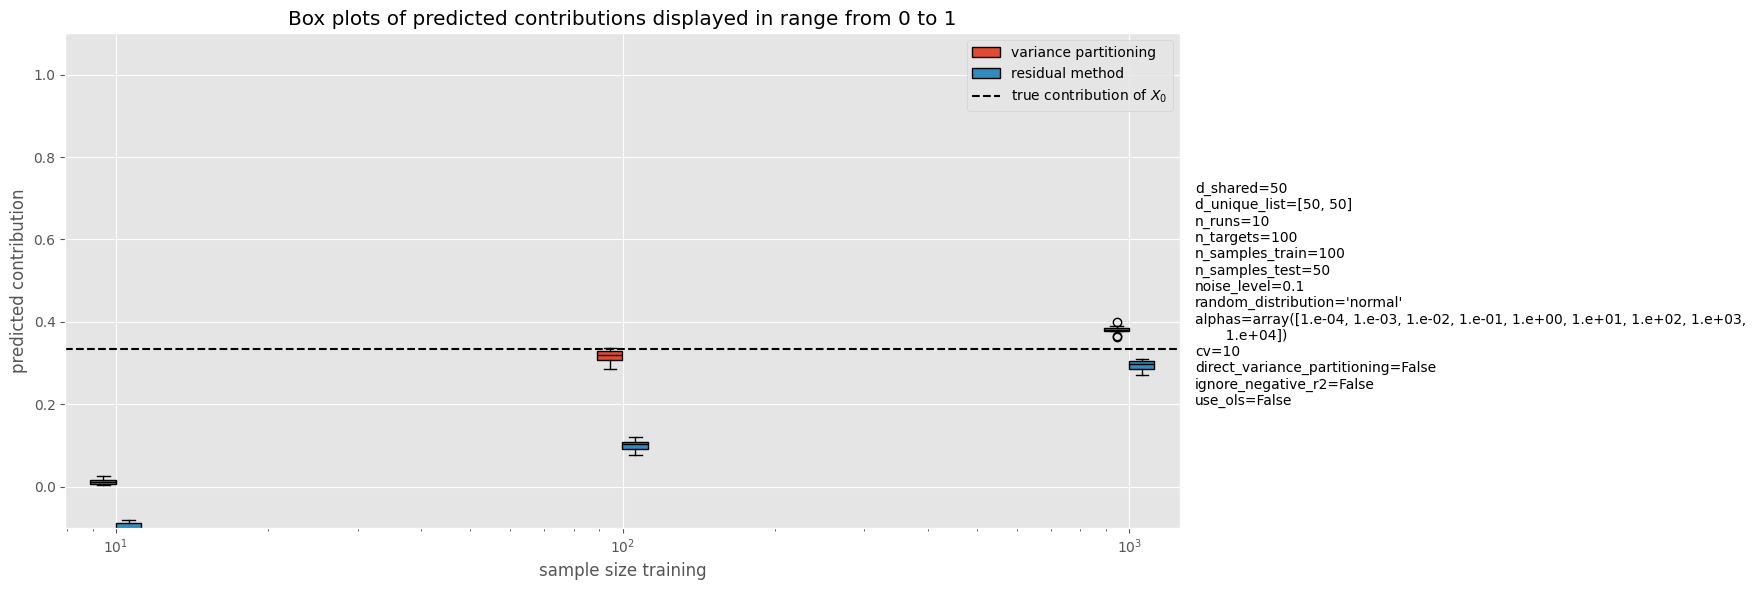

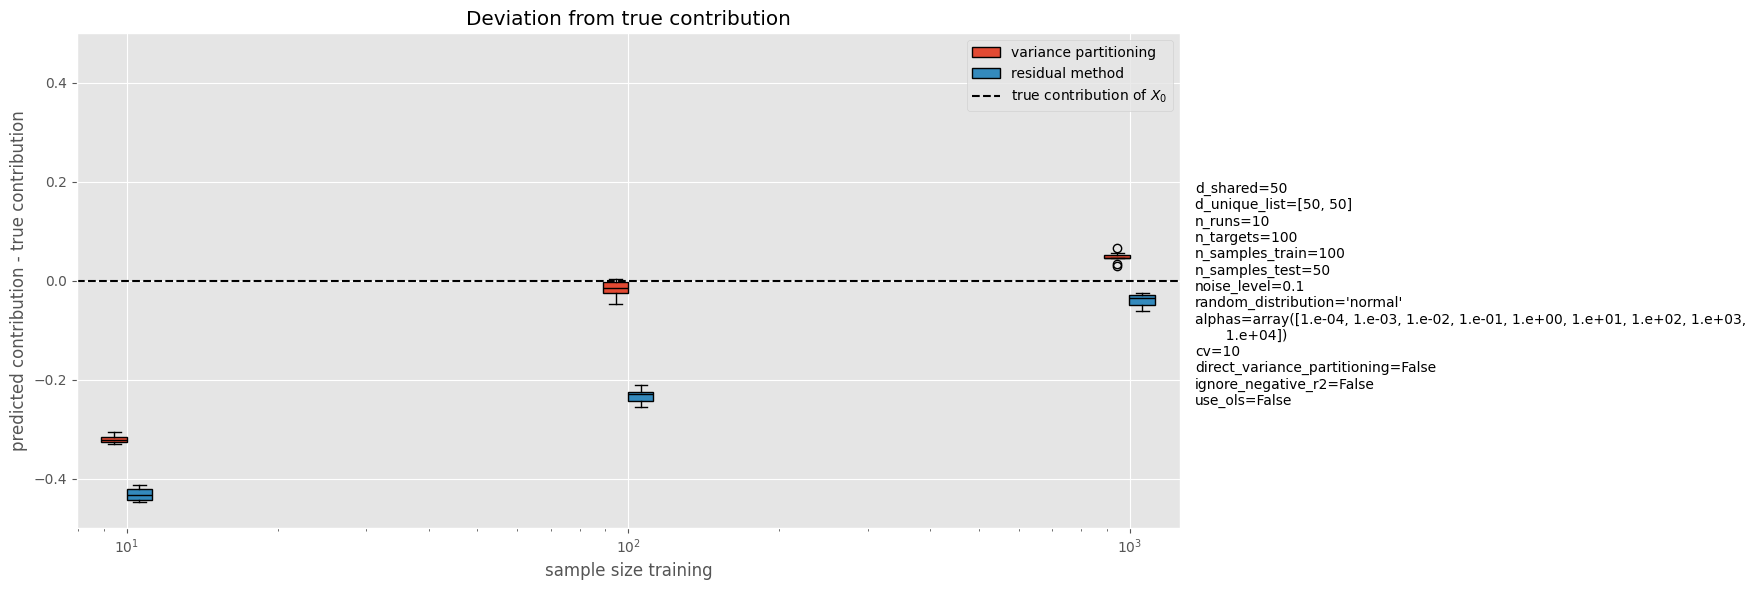

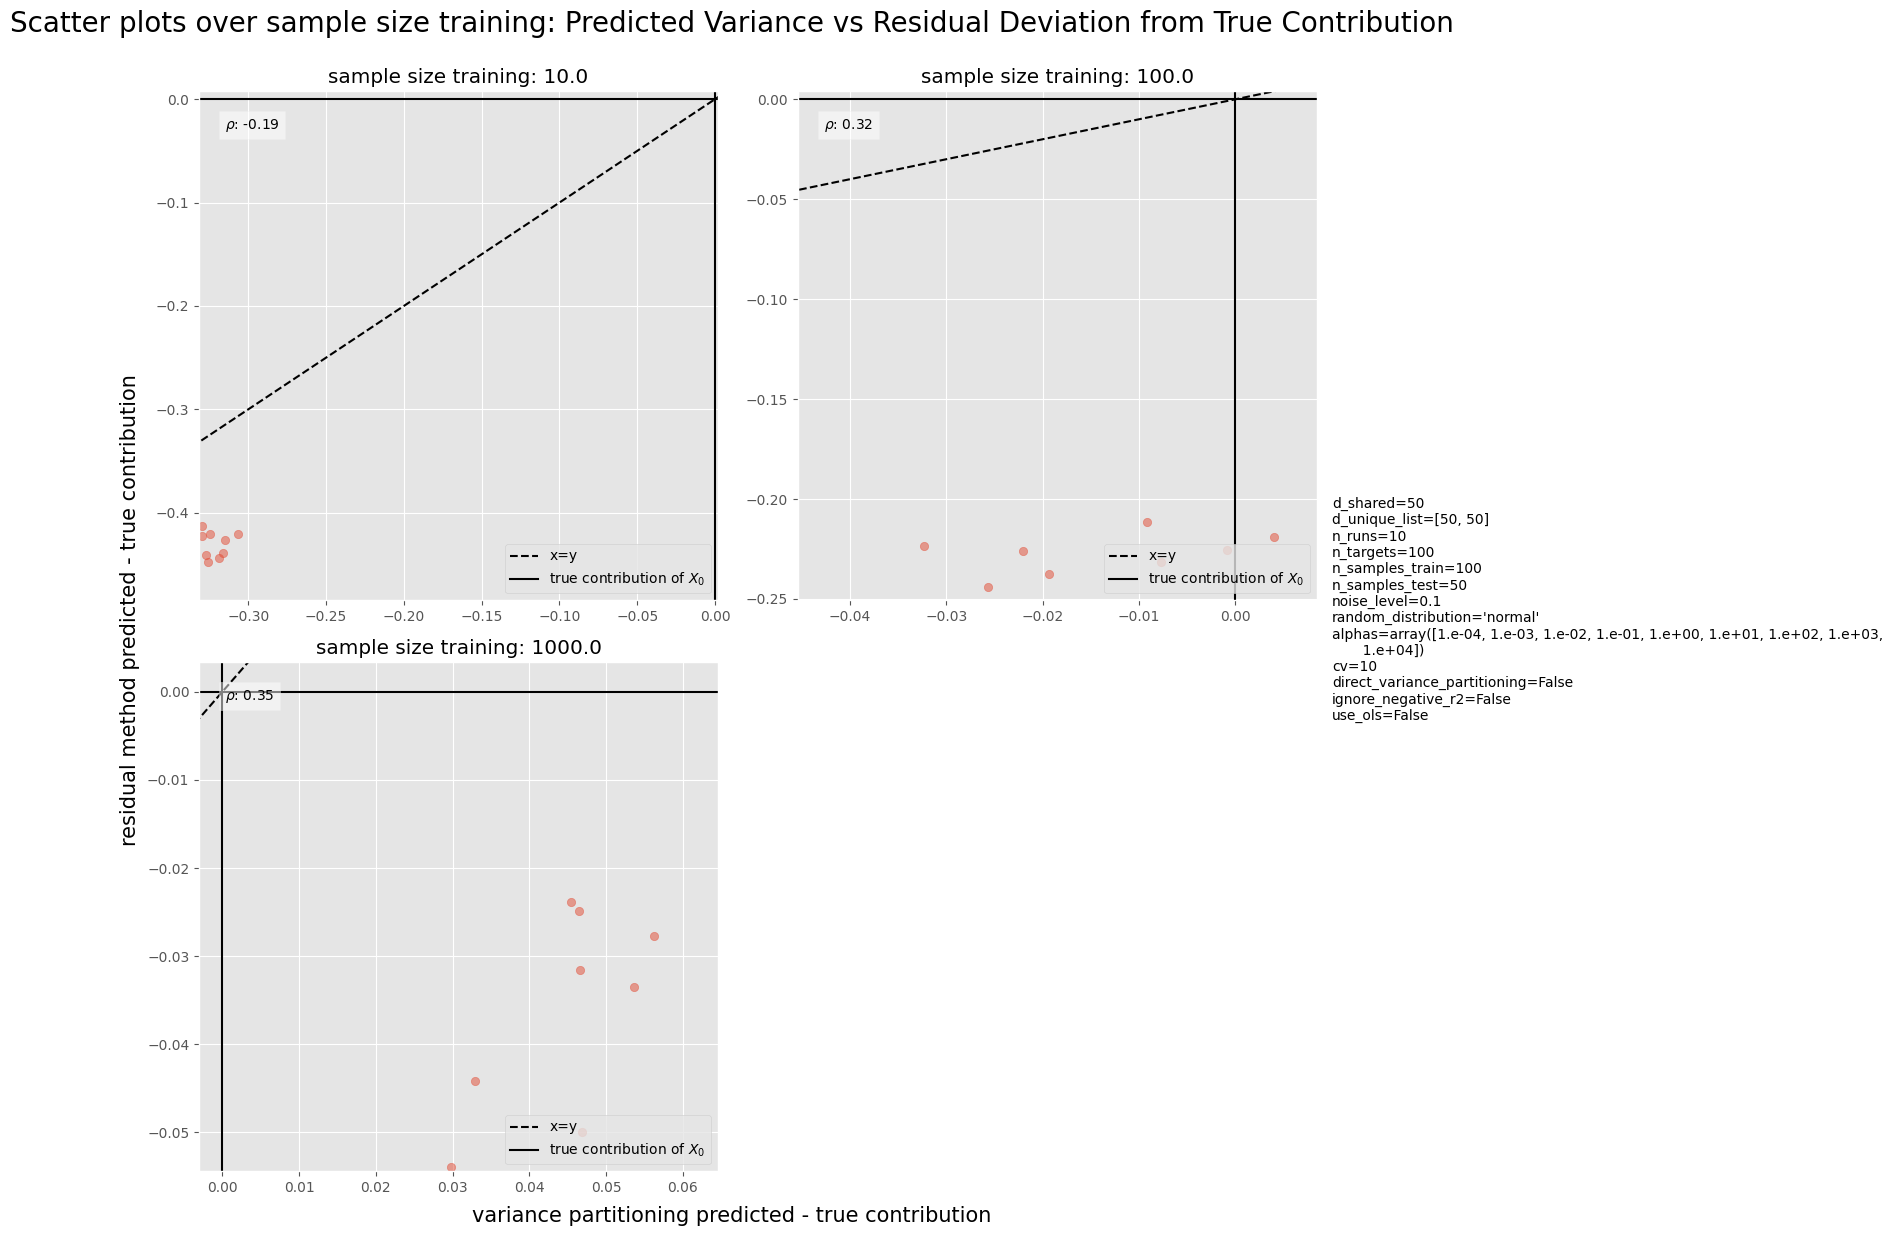

In [10]:
plot_experiment(sample_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

## varying test sample sizes

In [11]:
variable_name = "sample size testing"

In [12]:
predicted_variance, predicted_residual = run_experiment(sample_sizes, variable_name, **variables)

[........................................] 100% | 20.75 sec | Varying sample size testing | 


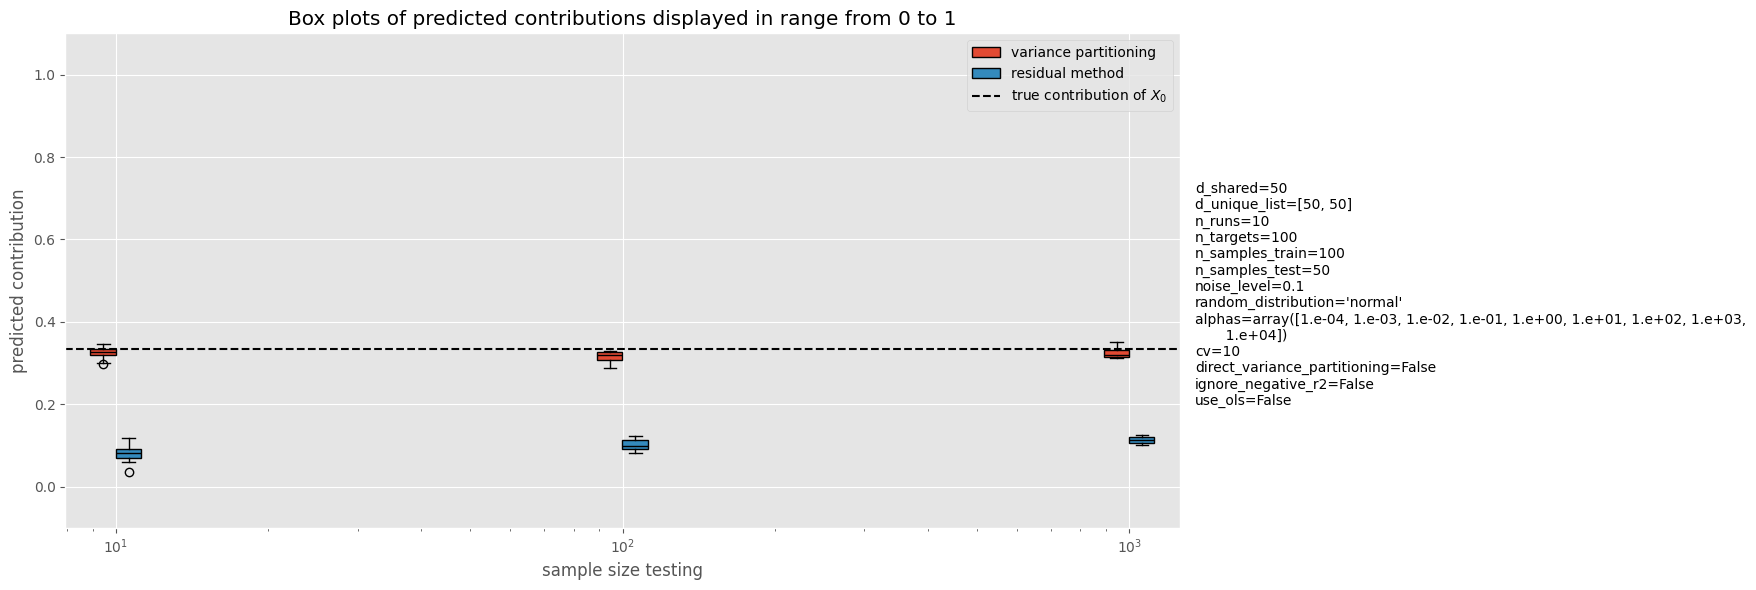

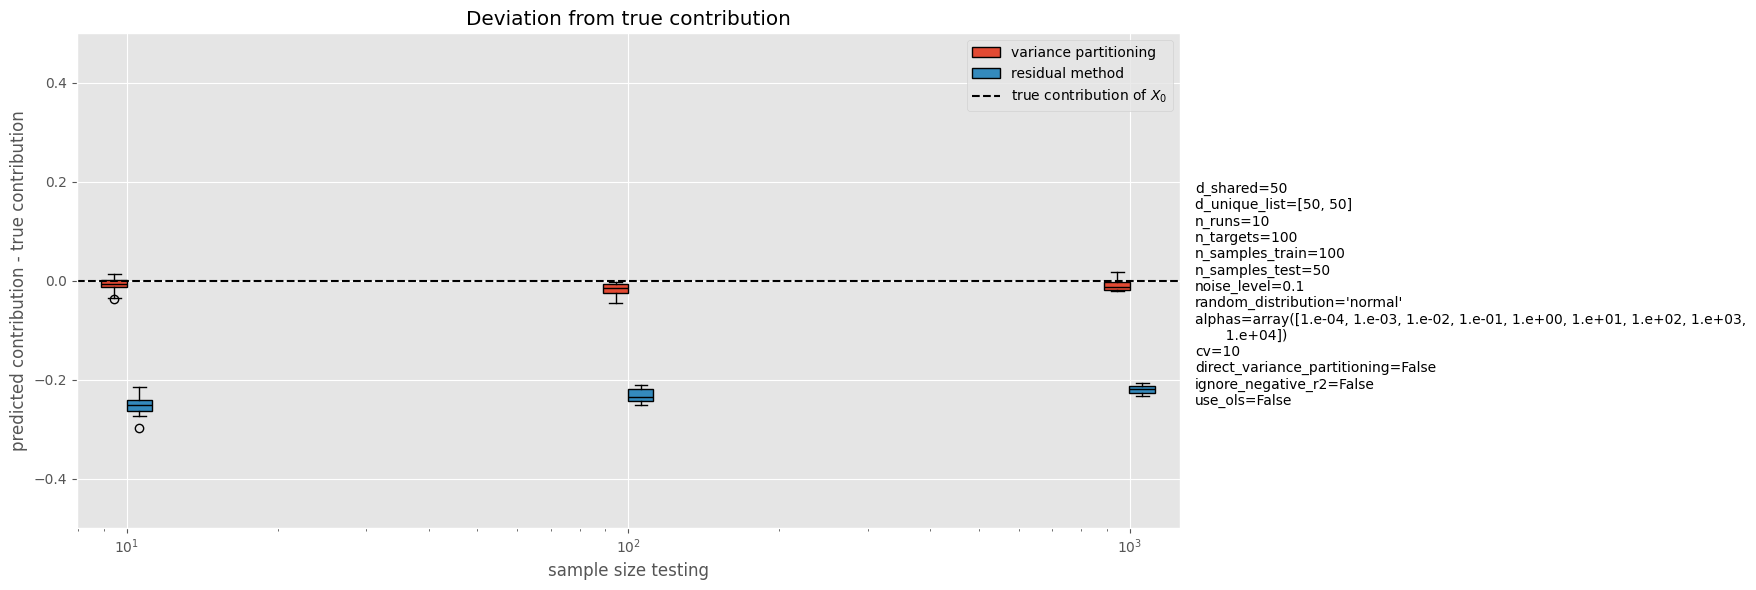

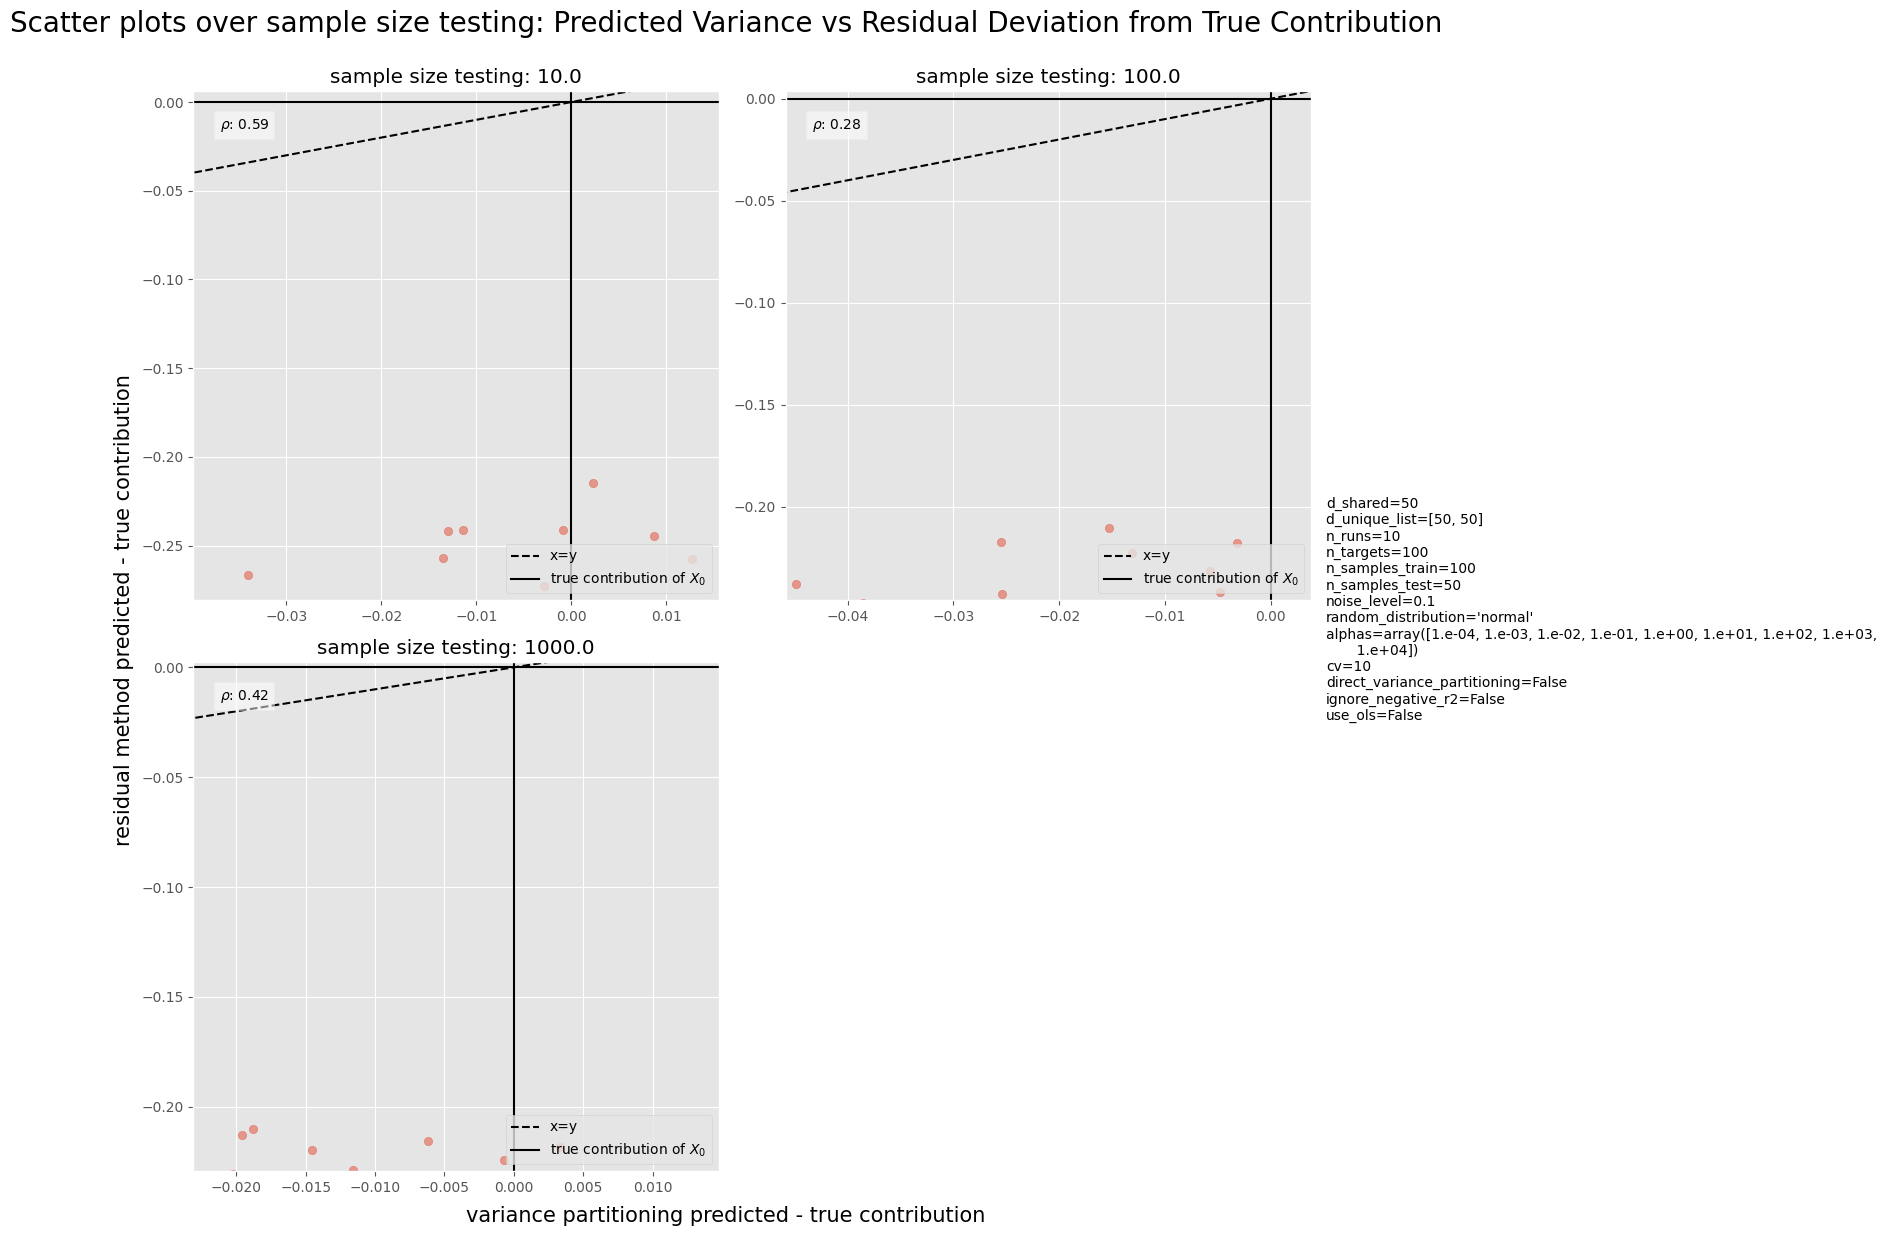

In [13]:
plot_experiment(sample_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

# Test varying feature sizes

In [14]:
feature_sizes = np.logspace(1, 3, n_observations)

## only $X_0$

In [15]:
# variable_name = "number of features $X_{0}$"

In [16]:
# predicted_variance, predicted_residual = run_experiment(feature_sizes, variable_name, **variables)

In [17]:
# plot_experiment(feature_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

## both $X_0$ and $X_1$

In [18]:
variable_name = "number of features $X_{0,1}$"

In [19]:
predicted_variance, predicted_residual = run_experiment(feature_sizes, variable_name, **variables)

[........................................] 100% | 19.98 sec | Varying number of features $X_{0,1}$ | 


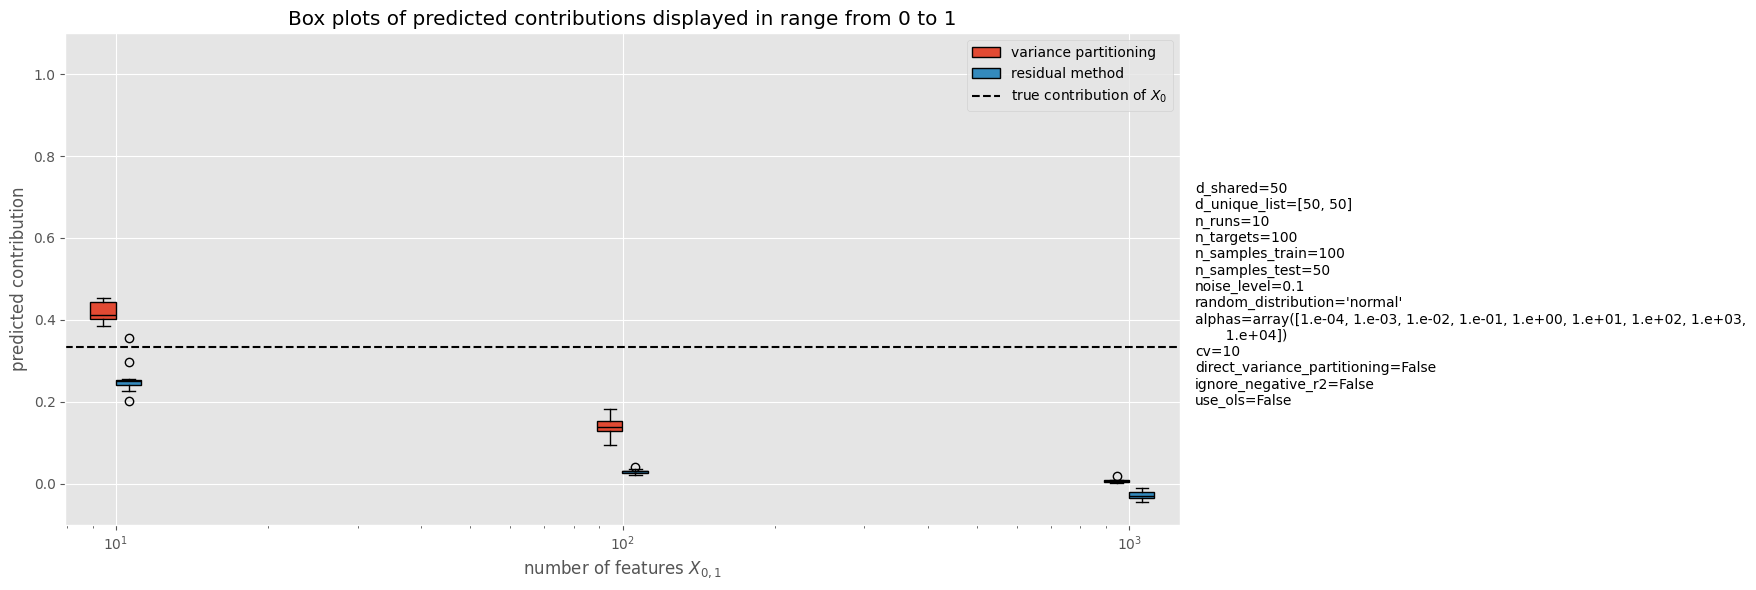

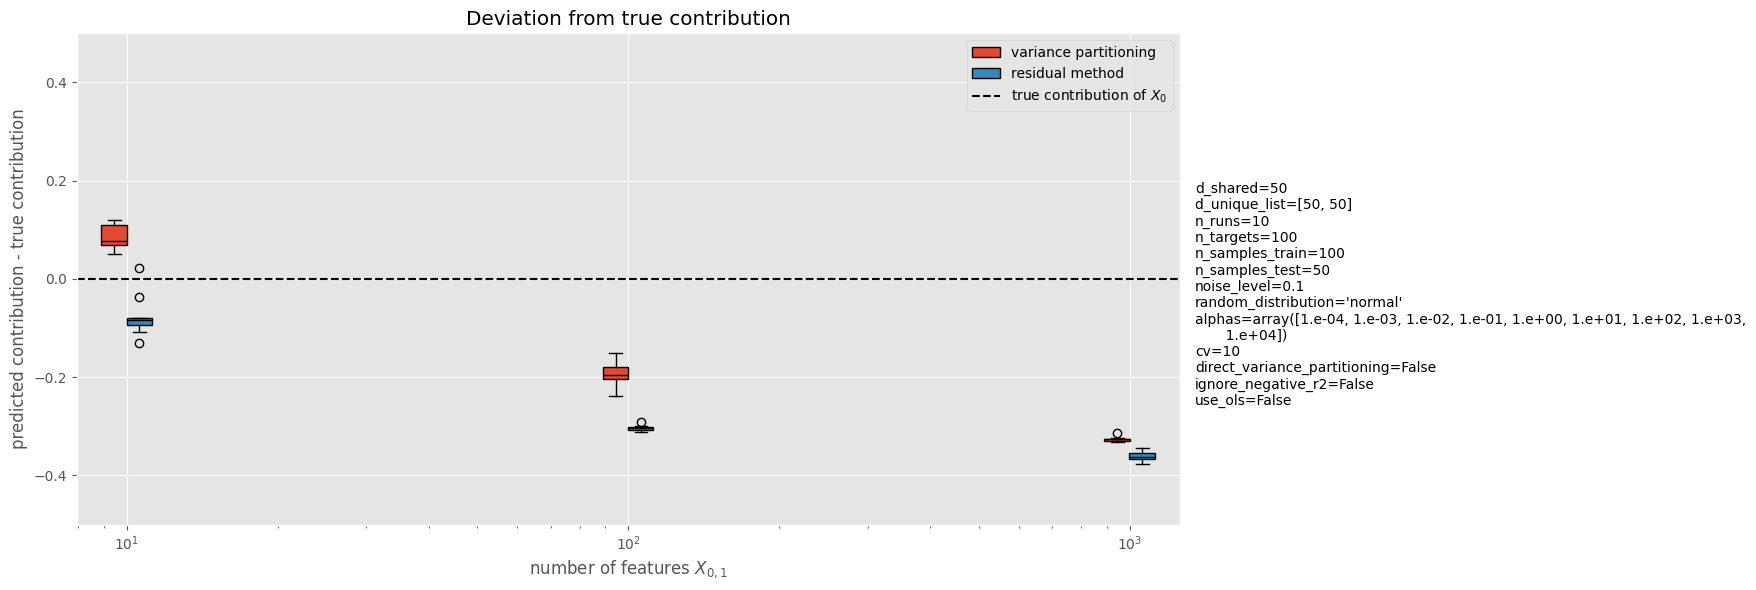

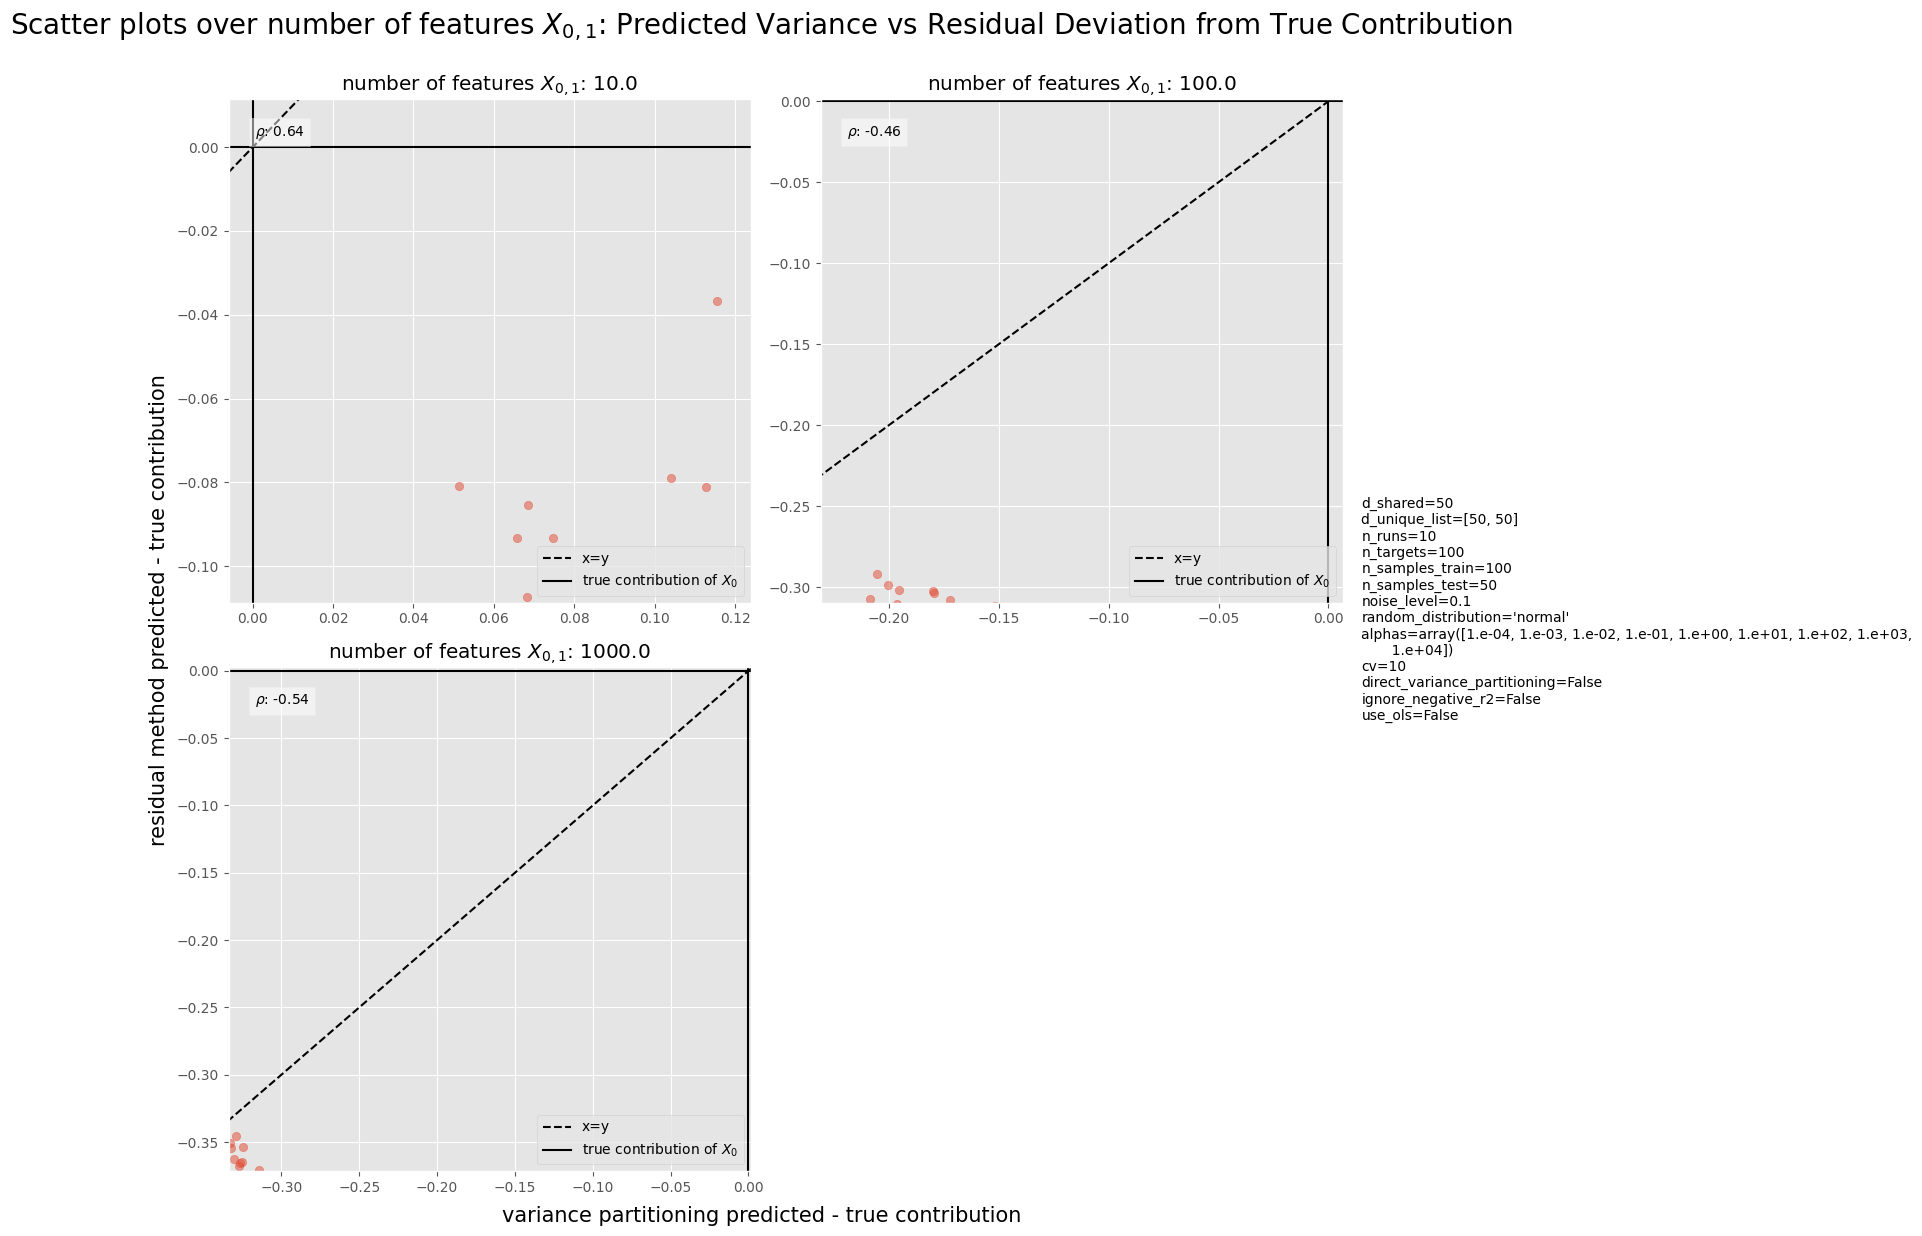

In [20]:
plot_experiment(feature_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

# varying target size

In [21]:
variable_name = "number of targets"
target_sizes = np.logspace(1, 3, n_observations)

In [22]:
predicted_variance, predicted_residual = run_experiment(target_sizes, variable_name, **variables)

[........................................] 100% | 20.39 sec | Varying number of targets | 


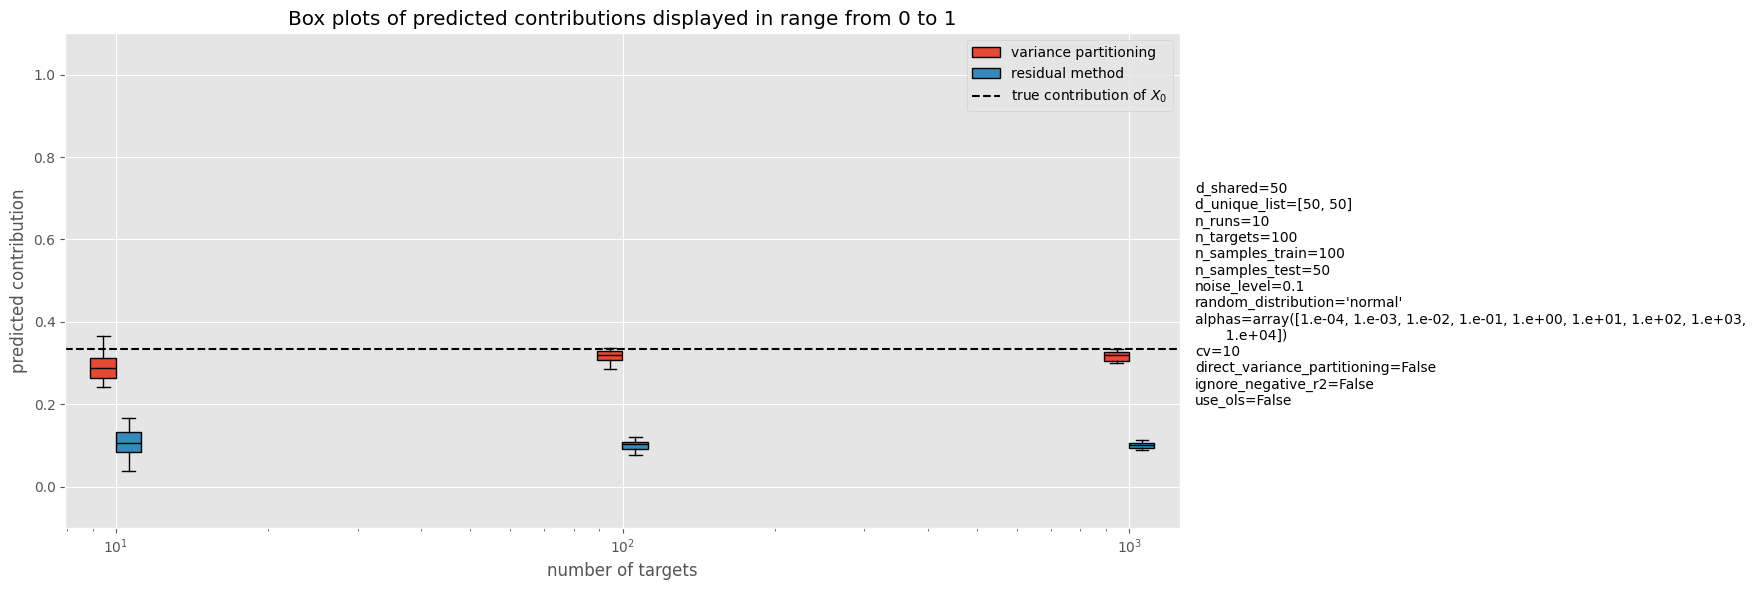

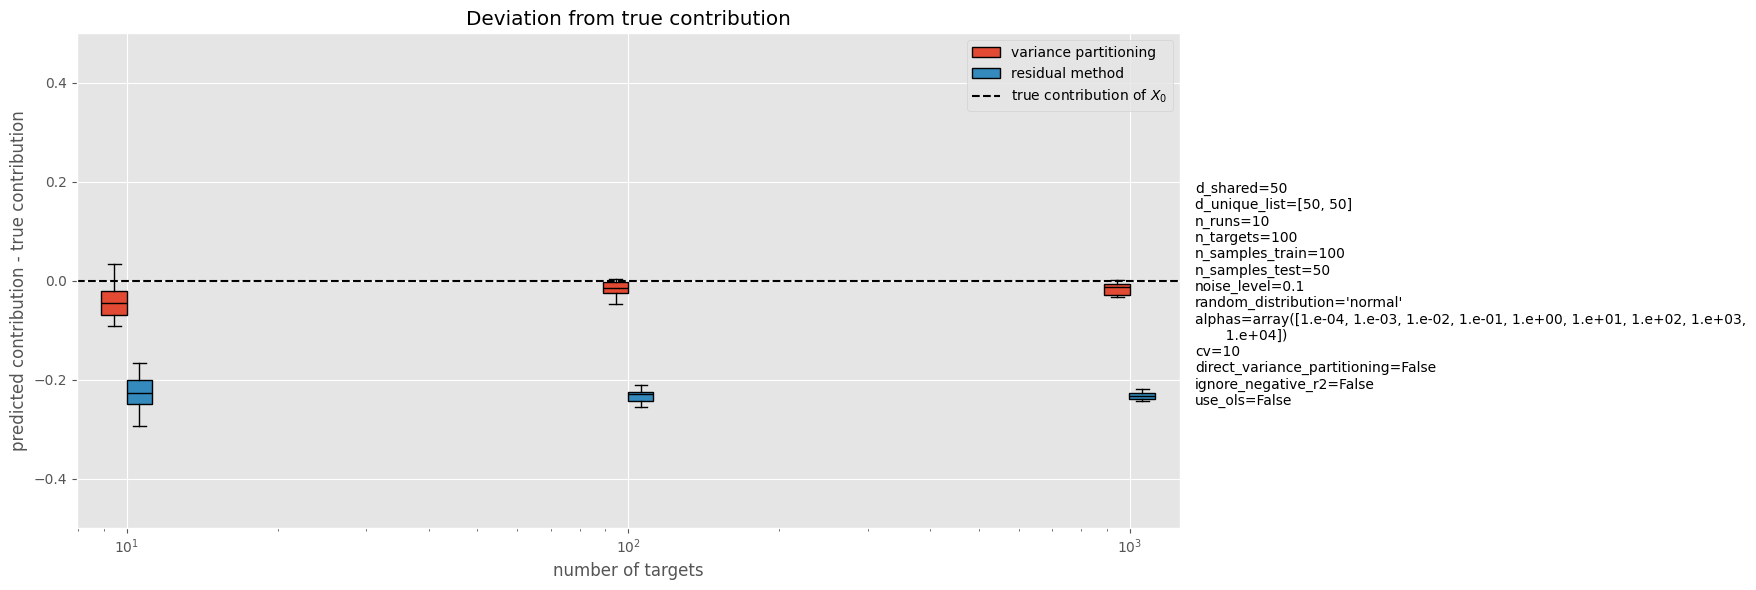

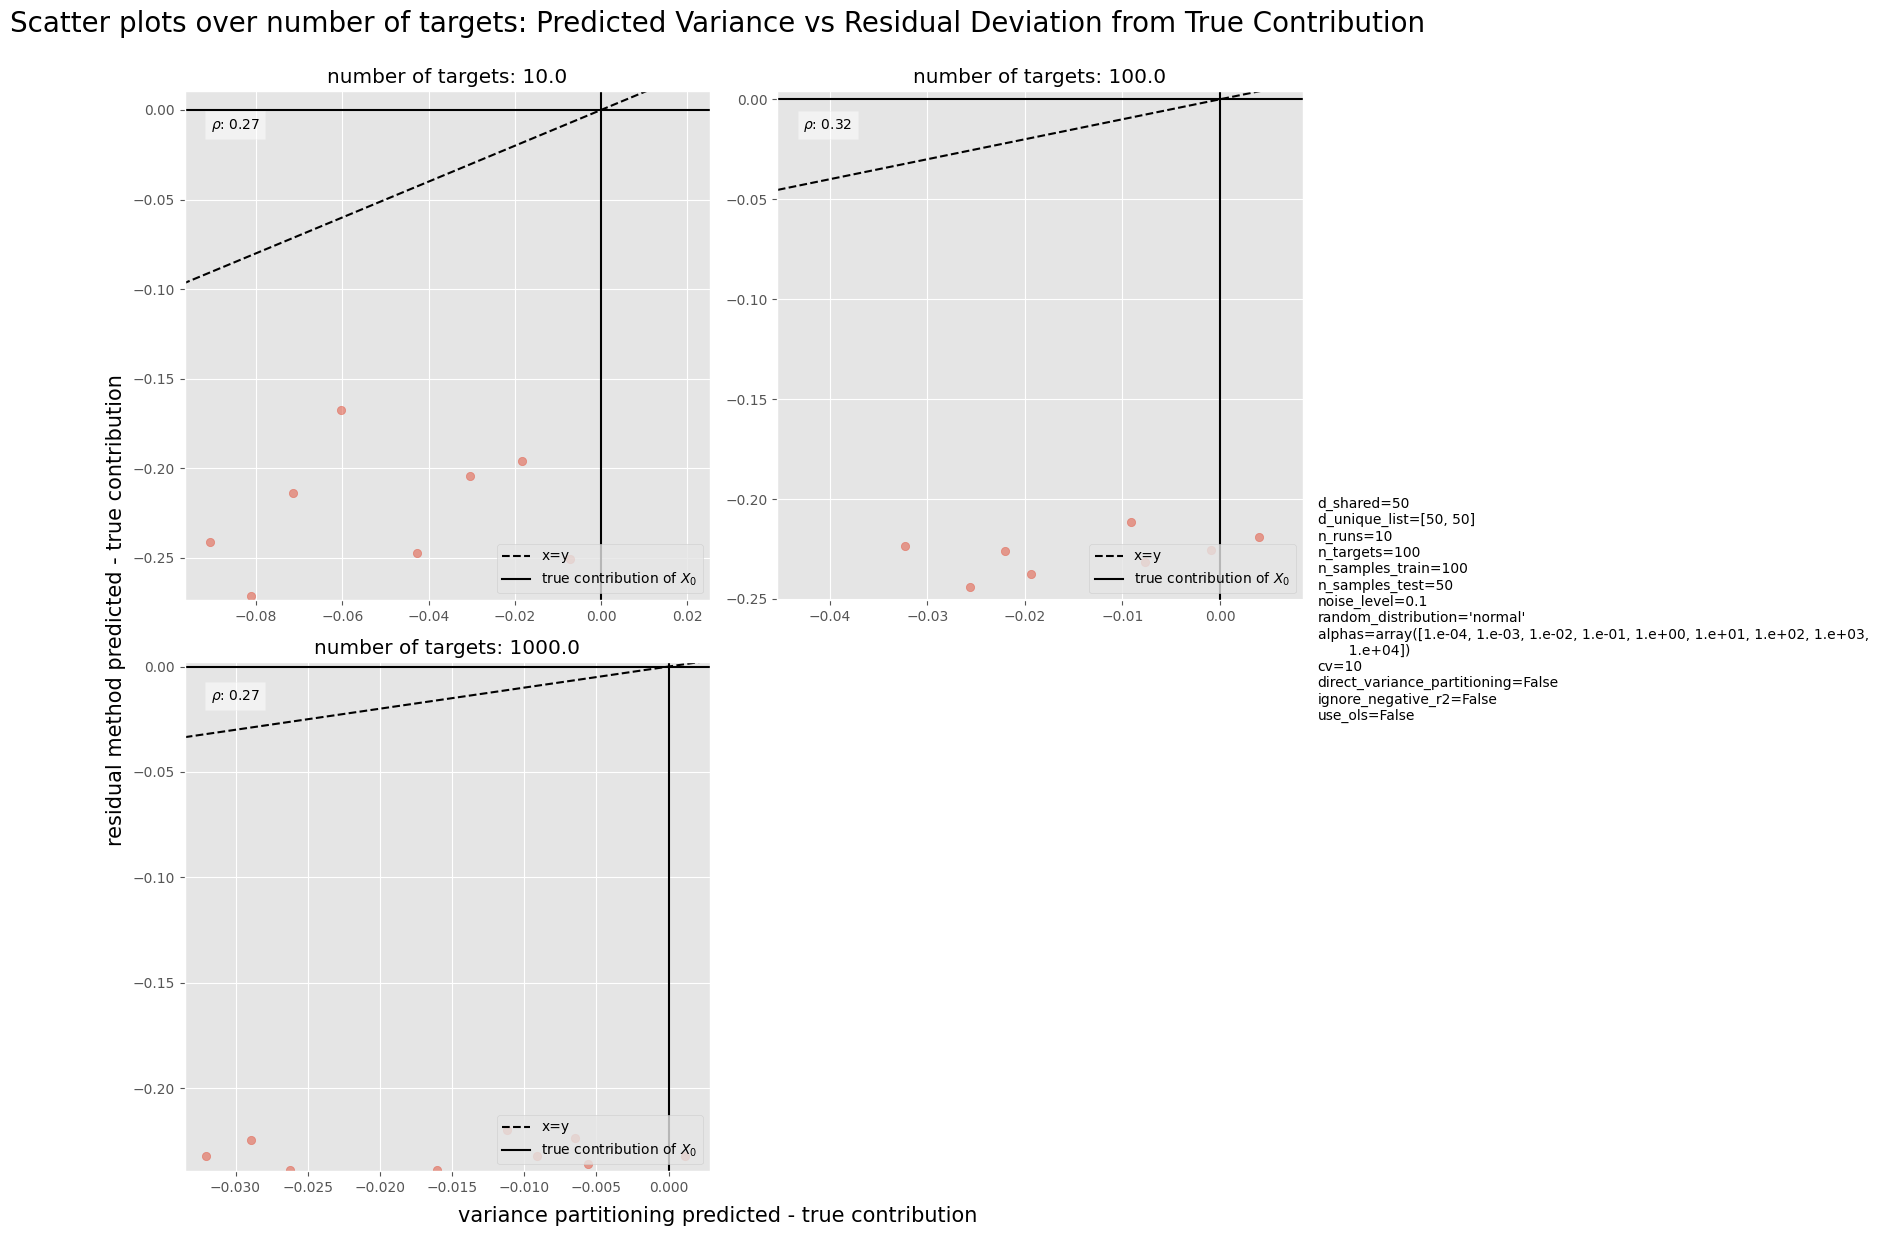

In [23]:
plot_experiment(target_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

# Test varying noise levels

In [24]:
variable_name = "relative amount of noise in the target"
noise_levels = np.linspace(0, 1, n_observations)

In [25]:
predicted_variance, predicted_residual = run_experiment(noise_levels, variable_name, **variables)

[..........................              ] 67% | 14.56 sec | Varying relative amount of noise in the target | 

KeyboardInterrupt: 

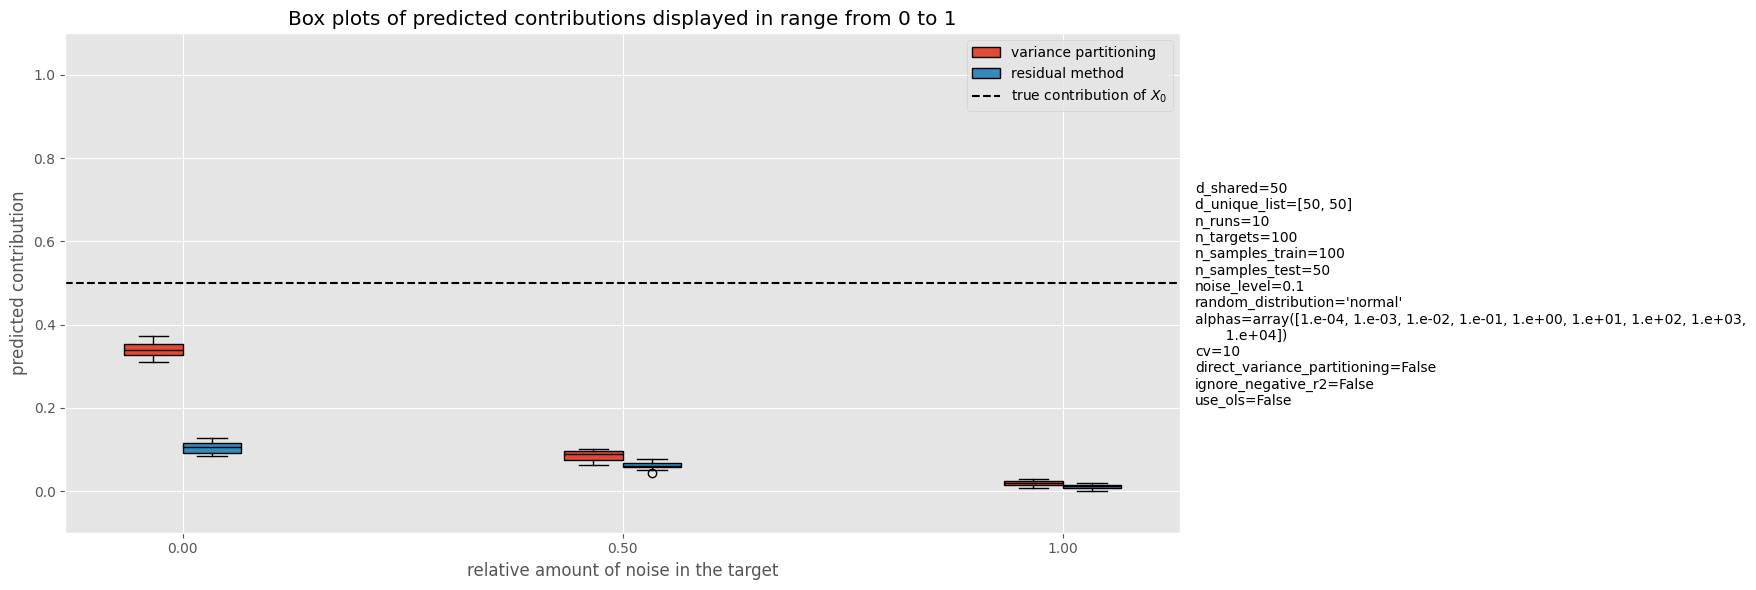

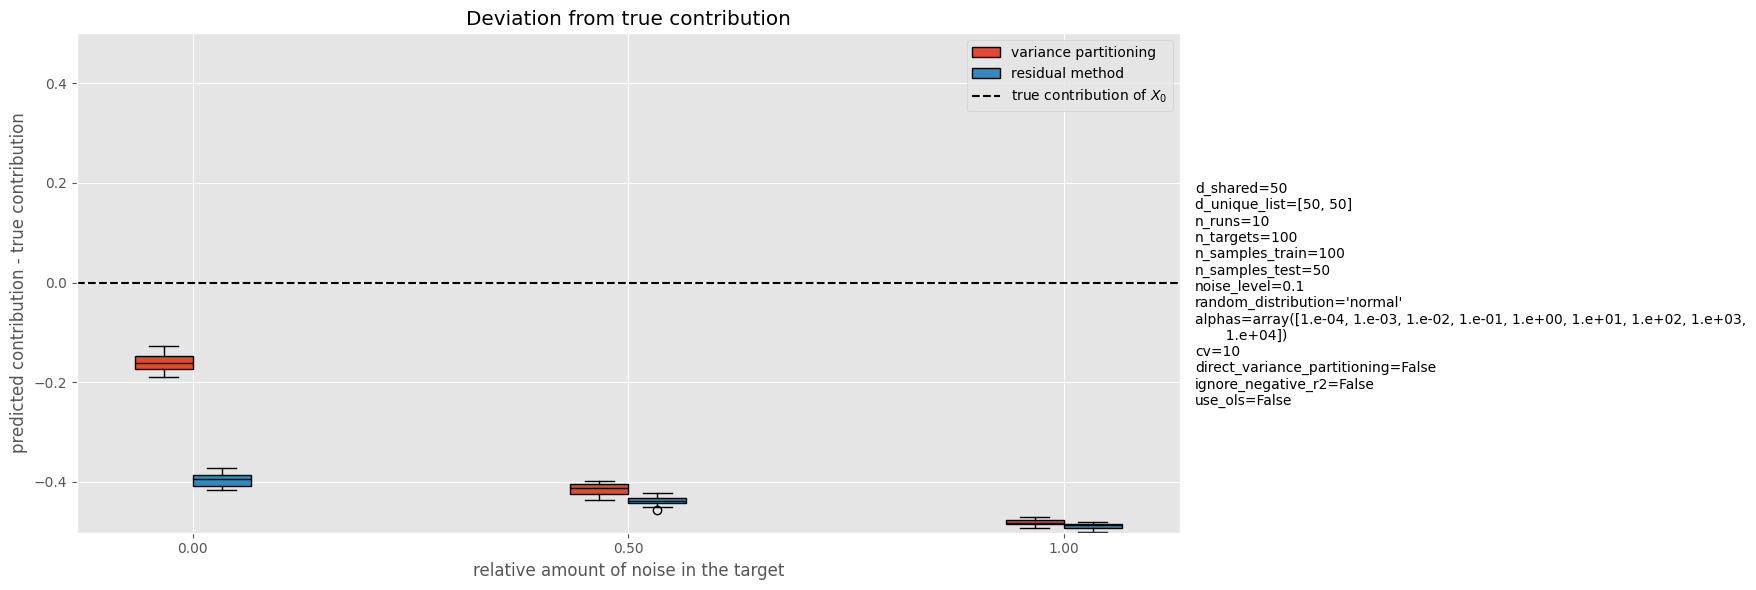

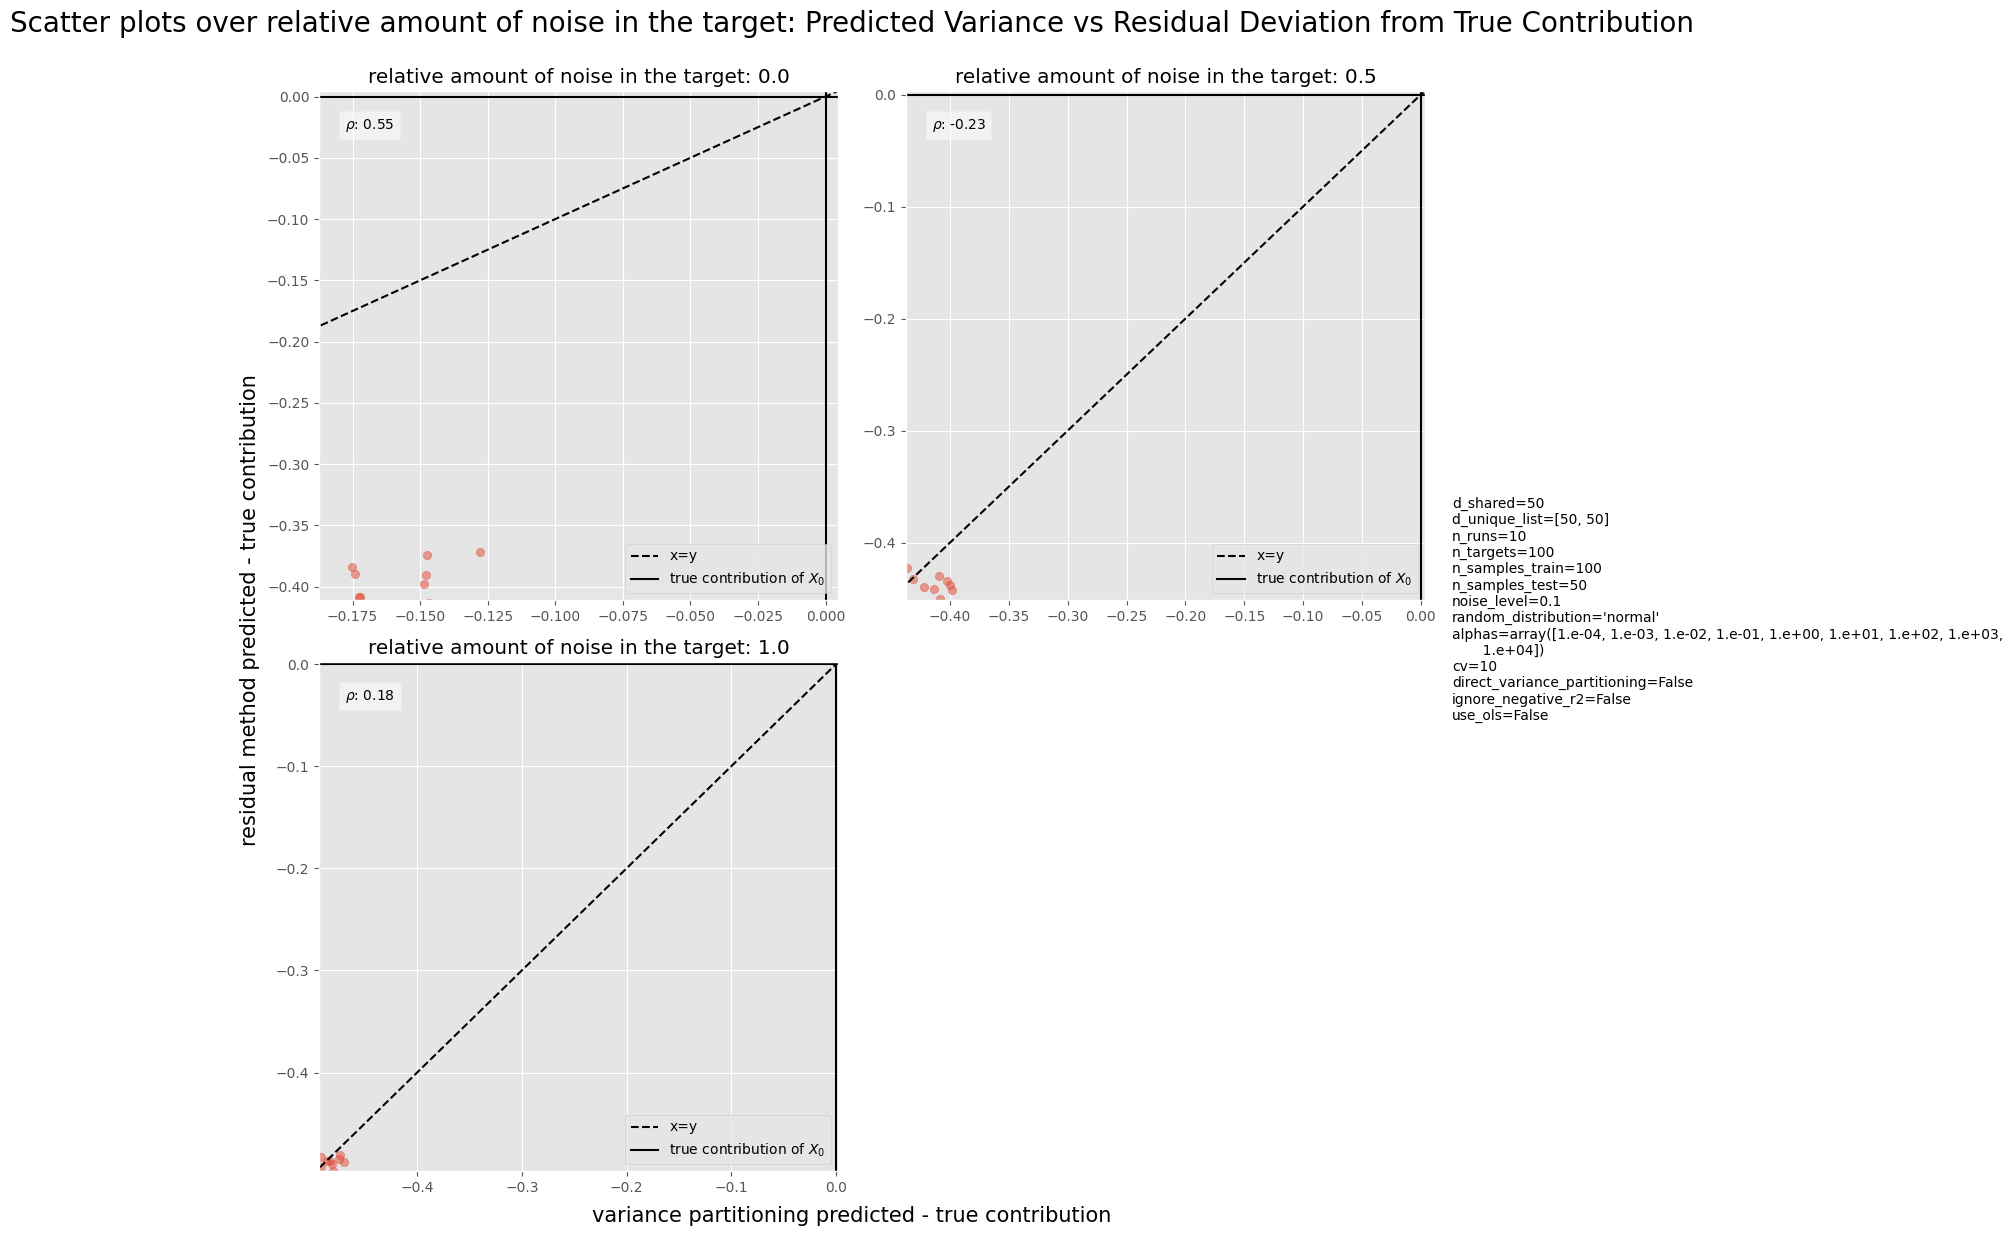

In [26]:
plot_experiment(noise_levels, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying unique contributions of $X_0$ and $X_1$

In [27]:
variable_name = "proportions of unique contribution"
x0_unique_contributions = np.linspace(0, 1, n_observations)
# convert from np to python
x0_unique_contributions = [round(float(x), 2) for x in x0_unique_contributions]

In [28]:
# for x0_unique_contribution in x0_unique_contributions:
#     contributions = [[x0_unique_contribution, round((1 - x0_unique_contribution) * x1 / (n_observations - 1), 2)] for
#                      x1 in range(n_observations)]
#     predicted_variance, predicted_residual = run_experiment(contributions, variable_name, **variables)
#     variables_without_unique_contributions = variables.copy()
#     variables_without_unique_contributions.__delitem__("unique_contributions")
#     plot_experiment(contributions, variable_name, predicted_variance, predicted_residual, unique_contributions=[x0_unique_contribution, "varying"], **variables_without_unique_contributions)